In [1]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


c:\repos\Kolesa-python-exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [3]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [4]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [5]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [6]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [7]:
data.dtypes

event_date    object
y              int64
dtype: object

In [8]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [9]:
data.columns = ['ds', 'y']
data.head()

,ds,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435


<Axes: xlabel='ds'>

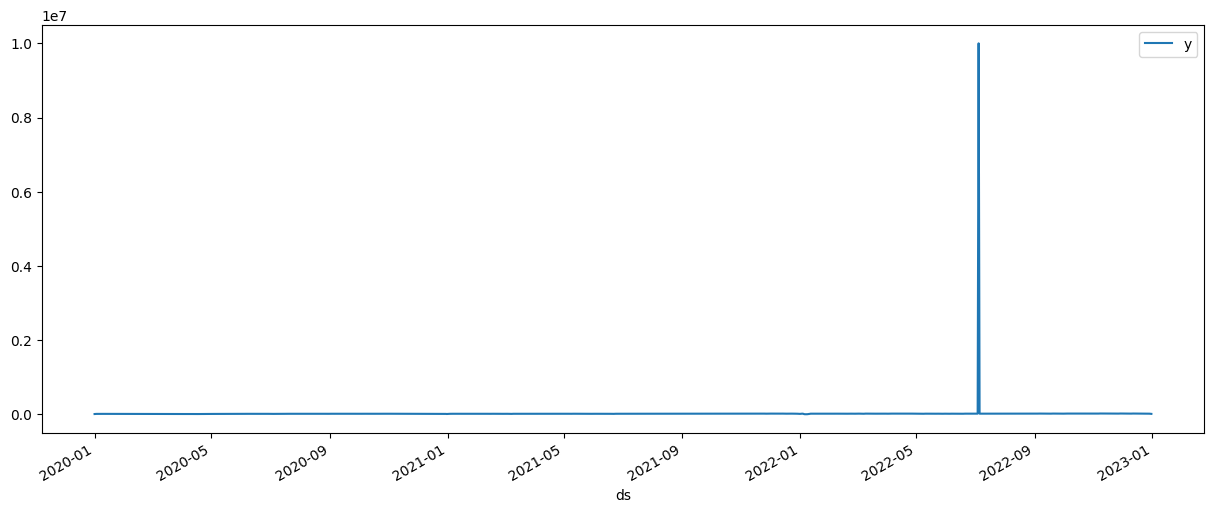

In [10]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [11]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_15776\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


<Axes: xlabel='ds'>

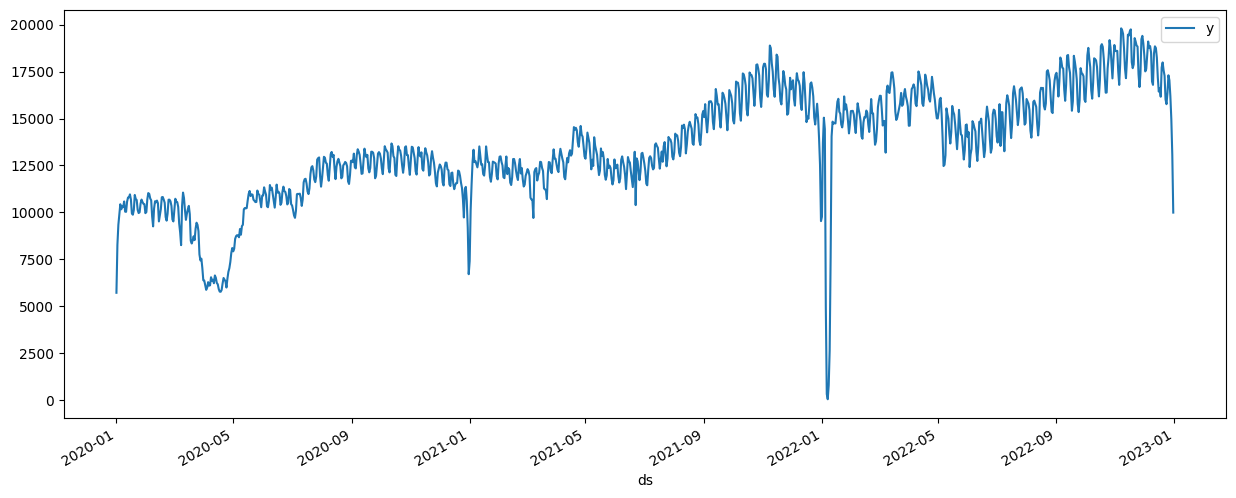

In [12]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [13]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

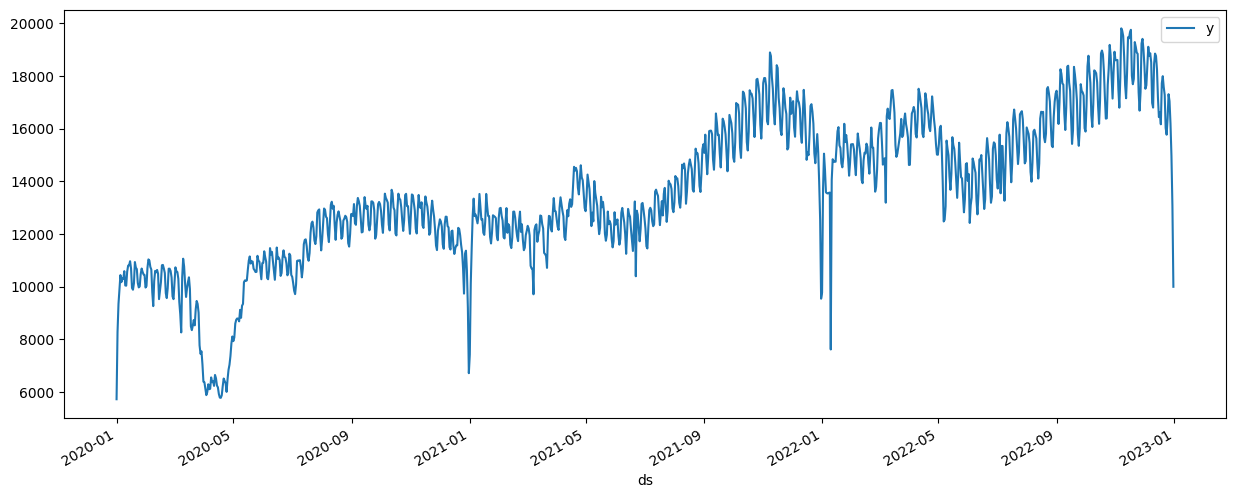

In [14]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [15]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


In [16]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)

def is_covid(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-03-16')) & (date <= pd.to_datetime('2020-06-01')))

data['is_covid'] = data['ds'].apply(is_covid)
data['covid'] = data['is_covid'].apply(int)
data.head()

,ds,y,is_ramadan,ramadan,is_covid,covid
376,2020-01-01,5721.0,False,0,False,0
345,2020-01-02,8274.0,False,0,False,0
532,2020-01-03,9344.0,False,0,False,0
574,2020-01-04,9864.0,False,0,False,0
843,2020-01-05,10435.0,False,0,False,0


In [17]:
# Функция для получения номера дня в году из даты
def get_day_of_year(ds):
    return pd.to_datetime(ds).dayofyear

# Преобразуем дату в номер дня в году
data['day_of_year'] = data['ds'].apply(get_day_of_year)

# Используем столбец 'y' в качестве целевой переменной
y = data['y'].values

# Используем номер дня в году в качестве признака
X = data[['day_of_year']]


In [18]:
from Models import LinearRegression

# Создаем и обучаем модель
daily_regressor = LinearRegression.MyDailyLinearRegression()
daily_regressor.fit(X.values, y)

# Получаем предсказания для каждого дня
predictions_daily = daily_regressor.predict(X.values)

# Вычисляем среднюю абсолютную ошибку
mae_daily = np.mean(np.abs(y - predictions_daily))
print("MAE для линейной регрессии по дням:", mae_daily)


MAE для линейной регрессии по дням: 2057.1812930340484


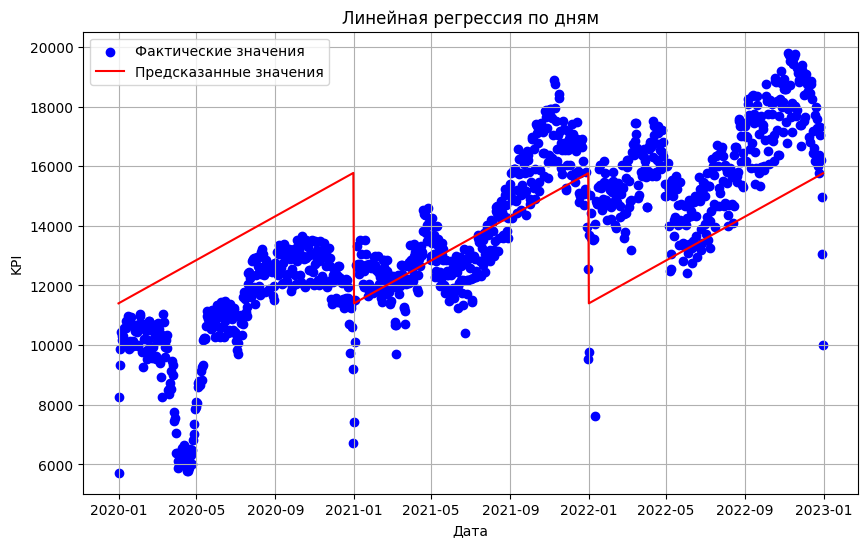

In [19]:
# Построение графика с фактическими значениями и предсказанными значениями
plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], y, color='blue', label='Фактические значения')
plt.plot(data['ds'], predictions_daily, color='red', label='Предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('KPI')
plt.title('Линейная регрессия по дням')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Используем номер дня в году в качестве признака
X = data[['day_of_year']]

# Используем данные о Рамадане и COVID-19 в качестве дополнительных признаков
ramadan = data['ramadan'].values
covid = data['covid'].values

# Создаем и обучаем модель
daily_regressor = LinearRegression.MyDailyLinearRegressionRamadan()
daily_regressor.fit(X.values, y, ramadan, covid)

# Получаем предсказания для каждого дня
predictions_daily = daily_regressor.predict(X.values, ramadan, covid)

# Вычисляем среднюю абсолютную ошибку
mae_daily = np.mean(np.abs(y - predictions_daily))
print("MAE для линейной регрессии по дням с учетом Рамадана и COVID-19:", mae_daily)

MAE для линейной регрессии по дням с учетом Рамадана и COVID-19: 1802.2608026564726


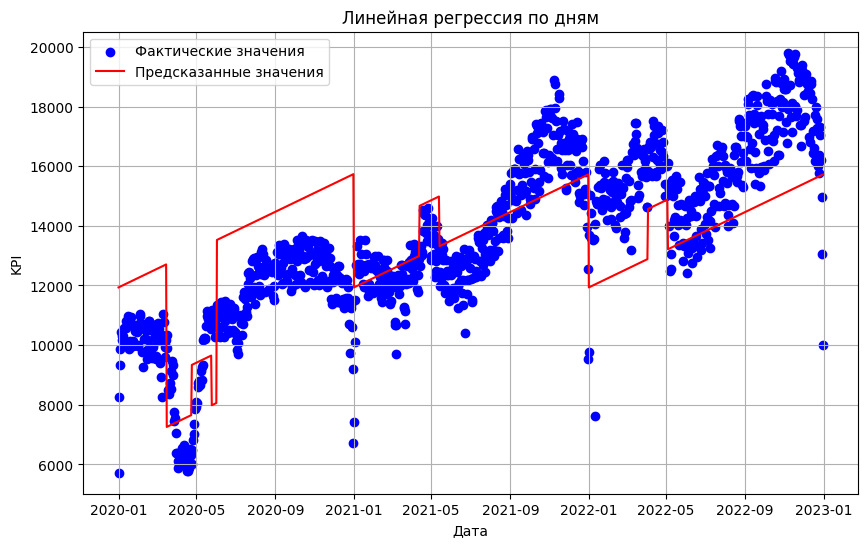

In [21]:
# Построение графика с фактическими значениями и предсказанными значениями
plt.figure(figsize=(10, 6))
plt.scatter(data['ds'], y, color='blue', label='Фактические значения')
plt.plot(data['ds'], predictions_daily, color='red', label='Предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('KPI')
plt.title('Линейная регрессия по дням')
plt.legend()
plt.grid(True)
plt.show()


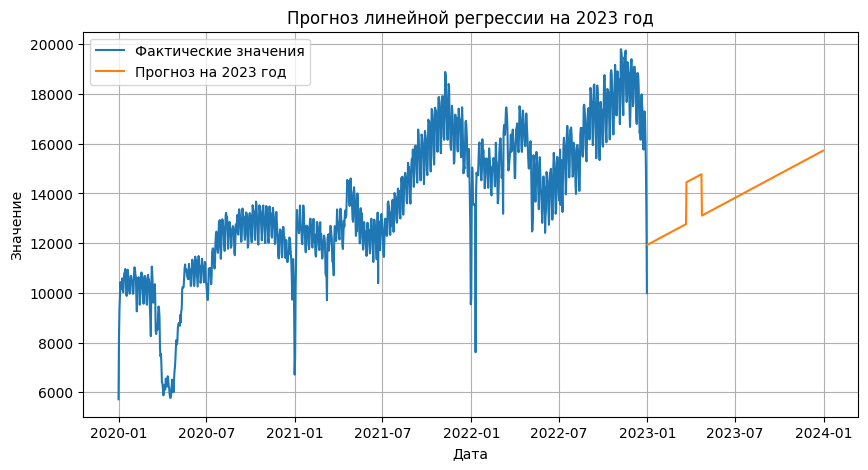

In [22]:
# Создание данных для 2023 года
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
X_2023 = pd.DataFrame({
    'ds': dates_2023,
})

# Преобразуем дату в номер дня в году
X_2023['day_of_year'] = X_2023['ds'].apply(get_day_of_year)

# Создание признаков 'ramadan' и 'covid' для 2023 года
X_2023['is_ramadan'] = X_2023['ds'].apply(is_ramadan).astype(int)
X_2023['is_covid'] = X_2023['ds'].apply(is_covid).astype(int)

# Получение предсказаний для 2023 года
predictions_2023 = daily_regressor.predict(X_2023[['day_of_year']], X_2023['is_ramadan'], X_2023['is_covid'])

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(data['ds'], y, label='Фактические значения')
plt.plot(X_2023['ds'], predictions_2023, label='Прогноз на 2023 год')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз линейной регрессии на 2023 год')
plt.legend()
plt.grid(True)
plt.show()


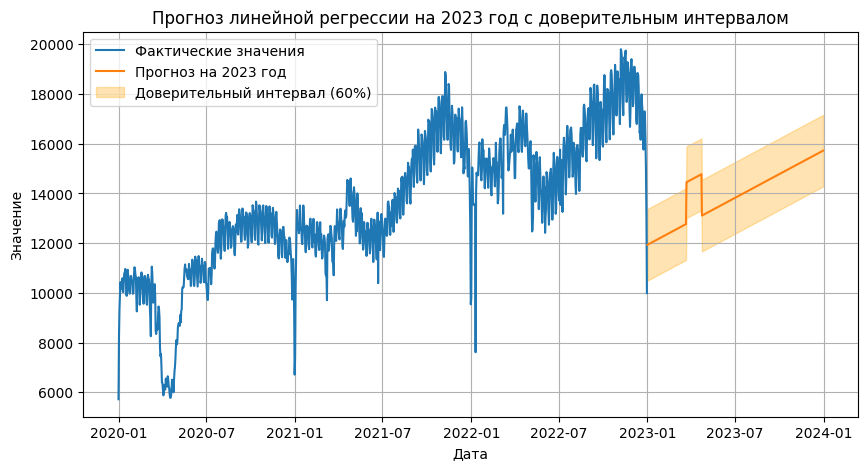

In [23]:

# Рассчитываем стандартную ошибку предсказания (SE)
SE = np.sqrt(np.sum((y - predictions_daily) ** 2) / (len(y) - 2))

# Коэффициент доверия (например, для 60% доверия)
confidence_coefficient = 0.675

# Рассчитываем доверительный интервал для 2023 года
lower_bound_2023 = predictions_2023 - confidence_coefficient * SE
upper_bound_2023 = predictions_2023 + confidence_coefficient * SE

# Визуализируем результаты с доверительным интервалом
plt.figure(figsize=(10, 5))
plt.plot(data['ds'], y, label='Фактические значения')
plt.plot(X_2023['ds'], predictions_2023, label='Прогноз на 2023 год')
plt.fill_between(X_2023['ds'], lower_bound_2023, upper_bound_2023, color='orange', alpha=0.3, label='Доверительный интервал (60%)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз линейной регрессии на 2023 год с доверительным интервалом')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# from sklearn.metrics import mean_absolute_error



# lr_values = [0.0001, 0.001, 0.01, 0.1]
# max_iter_values = [1000, 10000, 50000, 100000]
# sgd_values = [True, False]
# n_sample_values = [15, 30, 50, 100]

# best_mae = float('inf')
# best_hyperparameters = {}

# # Перебираем все комбинации гиперпараметров
# for lr in lr_values:
#     for max_iter in max_iter_values:
#         for sgd in sgd_values:
#             for n_sample in n_sample_values:
#                 # Создаем новую модель с текущими гиперпараметрами
#                 model = LinearRegression.MyDailyLinearRegressionRamadan(lr=lr, max_iter=max_iter, sgd=sgd, n_sample=n_sample)
#                 model.fit(X.values, y, data['ramadan'].values, data['covid'].values)
#                 predictions = model.predict(X.values)
#                 mae = mean_absolute_error(y, predictions)
#                 print(f"Hyperparameters: lr={lr}, max_iter={max_iter}, sgd={sgd}, n_sample={n_sample}, MAE={mae}")
                
#                 # Если текущее значение MAE лучше предыдущего лучшего, сохраняем параметры
#                 if mae < best_mae:
#                     best_mae = mae
#                     best_hyperparameters = {'lr': lr, 'max_iter': max_iter, 'sgd': sgd, 'n_sample': n_sample}

# print("Best hyperparameters:", best_hyperparameters)
# print("Best MAE:", best_mae)

In [25]:
# # Создаем модель с лучшими параметрами
# best_model = LinearRegression.MyDailyLinearRegressionRamadan(lr=best_hyperparameters['lr'], 
#                                             max_iter=best_hyperparameters['max_iter'], 
#                                             sgd=best_hyperparameters['sgd'], 
#                                             n_sample=best_hyperparameters['n_sample'])

# # Обучаем модель
# best_model.fit(X.values, y, data['ramadan'].values, data['covid'].values)

# # Получаем предсказания для каждого дня
# predictions_best = best_model.predict(X.values)

# # Вычисляем среднюю абсолютную ошибку
# mae_best = mean_absolute_error(y, predictions_best)
# print("Best MAE:", mae_best)


In [26]:
# # Визуализация предсказаний и фактических значений
# plt.figure(figsize=(10, 6))
# plt.plot(data['ds'], y, label='Фактические значения', color='blue')
# plt.plot(data['ds'], predictions_best, label='Предсказанные значения', color='red')
# plt.xlabel('Дата')
# plt.ylabel('KPI')
# plt.title('Предсказания лучшей модели')
# plt.legend()
# plt.grid(True)
# plt.show()


In [27]:
# # Создание данных для 2023 года
# dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31')
# X_2023 = pd.DataFrame({'ds': dates_2023})
# X_2023['day_of_year'] = X_2023['ds'].apply(get_day_of_year)

# # Предсказание значений для 2023 года
# predictions_2023 = daily_regressor.predict(X_2023[['day_of_year']].values)

# # Создание небольшого доверительного интервала (например, 5%)
# confidence_interval = 0.05
# prediction_std = np.std(y - predictions_daily)
# upper_confidence = predictions_2023 + 0.8 * prediction_std
# lower_confidence = predictions_2023 - 0.8 * prediction_std

# # Визуализация предсказаний на 2023 год с доверительным интервалом
# plt.figure(figsize=(10, 6))
# plt.plot(X_2023['ds'], predictions_2023, label='Предсказанные значения', color='red')
# plt.fill_between(X_2023['ds'], lower_confidence, upper_confidence, color='pink', alpha=0.3, label='Доверительный интервал')
# plt.xlabel('Дата')
# plt.ylabel('KPI')
# plt.title('Предсказания на 2023 год')
# plt.legend()
# plt.grid(True)
# plt.show()


In [28]:
# # Визуализация общих данных и предсказаний на 2023 год
# plt.figure(figsize=(12, 6))
# plt.plot(data['ds'], data['y'], label='Фактические значения', color='blue')
# plt.plot(X_2023['ds'], predictions_2023, label='Предсказанные значения на 2023 год', color='red')
# plt.fill_between(X_2023['ds'], lower_confidence, upper_confidence, color='pink', alpha=0.3, label='Доверительный интервал')
# plt.xlabel('Дата')
# plt.ylabel('KPI')
# plt.title('Предсказания на 2023 год с общими данными')
# plt.legend()
# plt.grid(True)
# plt.show()
